In [36]:
import cv2
import numpy as np
import os
import random
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'ml66-data/train/'
TEST_DIR = 'ml66-data/test/'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscat-{}-{}.model'.format(LR, '6conv-basic')

In [2]:
def label_image(img):
    # dog.93.png
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1, 0]
    elif word_label == 'dog': return [0, 1]

In [3]:
def create_training_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_image(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))

        training_data.append([np.array(img), np.array(label)])
    
    shuffle(training_data)
    np.save('ml66-data/train_data.npy', np.array(training_data, dtype=object))
    return training_data

In [17]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    
    np.save('ml66-data/test_data.npy', np.array(testing_data, dtype=object))
    return testing_data

In [5]:
train_data = create_training_data()

100%|██████████| 25000/25000 [00:12<00:00, 2060.85it/s]


In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tensorflow.python.framework import ops
ops.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, 
                     loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='ml66-data/log')

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
if os.path.exists('ml66-data/{}.meta'.format(MODEL_NAME)):
    model.load('ml66-data/' + MODEL_NAME)
    print("Model loaded")

In [8]:
train = train_data[:-500]
test = train_data[-500:]

In [9]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in train]

In [10]:
model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.35332 | time: 3.533s
| Adam | epoch: 010 | loss: 0.35332 - acc: 0.8526 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.35149 | time: 4.976s
| Adam | epoch: 010 | loss: 0.35149 - acc: 0.8517 | val_loss: 0.33037 - val_acc: 0.8520 -- iter: 24500/24500
--


In [11]:
model.save('ml66-data/' + MODEL_NAME)
print("done")

INFO:tensorflow:c:\Users\Aweso\our-code\MachineLearning\ml66-data\dogsvscat-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.
done


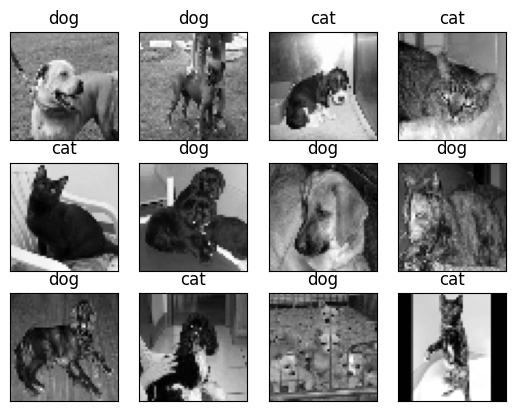

In [38]:
import matplotlib.pyplot as plt

# test_data = process_test_data()
test_data = np.load('ml66-data/test_data.npy', allow_pickle=True)
num = random.randrange(0, len(test_data) - 12)
fig = plt.figure()

for num, data in enumerate(test_data[num: num + 12]):
    # cat: [1, 0]
    # dog [0, 1]

    img_num = data[1]
    img_data = data[0]

    y = fig.add_subplot(3, 4, num + 1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)

    model_out = model.predict([data])[0]

    if np.argmax(model_out) == 1: str_label = 'dog'
    else: str_label = 'cat'

    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [39]:
with open("ml66-data/submission-file.csv", 'w') as f:
    f.write('id,label\n')

In [40]:
with open("ml66-data/submission-file.csv", 'a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]

        data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[1]))

100%|██████████| 12500/12500 [00:12<00:00, 1009.11it/s]
